In [2]:
from IPython.core.display import display, HTML
display(HTML(
"""<style>
div.container { width:100% !important; }
div.CodeMirror {font-family: Consolas; font-size: 25pt;}
div.output { font-size: 20pt; font-weight: bold;}
div.input { font-family: Consolas; font-size: 30pt;}
div.prompt { min-width: 100px;}
</style>
"""))

C:\Users\HKEDU\AppData\Local\Temp\ipykernel_13376\135966390.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [23]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU \
                                                                , UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델을 만듭니다.

In [25]:
# 판별자 모델을 만듭니다.
discriminator = Sequential()
#strides:가로세로 크기가 더 줄어들어 새로운 특징을 뽑아 주는 효과가 생김
#        Dropout이나 풀링처럼 새로운 필터를 적용한 효과가 생긴다.
#        strides=2 : 2칸씩 이동  
#        설정을 하지않으면 기본값이 1이다. 
# input_shape=(28,28,1) : 크기를 28로 맞춰준다.
discriminator.add(Conv2D(64,kernel_size=5,strides=2,input_shape=(28,28,1),padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) # 2차원을 1차원으로 
discriminator.add(Dense(1, activation='sigmoid'))#판별결과가 1(진짜)이나 0(가짜)이 나오면 됨
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [26]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output  = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss="binary_crossentropy", optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [32]:
(X_train, _), (_,_) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32')
X_train.shape

(60000, 28, 28, 1)

In [33]:
def gan_train(epoch,batch_size, saving_interval):
    # 테스트과정은 필요 없고 이미지만 가져오기 위해서
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5 
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print(f"{i}번째 : d_loss : {d_loss} , g_loss = {g_loss}")

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            
            gen_imgs = 0.5 * gen_imgs + 0.5
            
            ## 이미지 출력하기 위한 변수
            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1

            fig.savefig(f"./data/gan_mnist_{i}.png")

1/1 [==============================] - 0s 81ms/step
0번째 : d_loss : 0.709200531244278 , g_loss = 0.5265939831733704
1/1 [==============================] - 0s 47ms/step
1번째 : d_loss : 0.48881033062934875 , g_loss = 0.18282246589660645
1/1 [==============================] - 0s 46ms/step
2번째 : d_loss : 0.5439845006912947 , g_loss = 0.056577168405056
1/1 [==============================] - 0s 46ms/step
3번째 : d_loss : 0.5723433289676905 , g_loss = 0.061506301164627075
1/1 [==============================] - 0s 51ms/step
4번째 : d_loss : 0.5455958563834429 , g_loss = 0.15807481110095978
1/1 [==============================] - 0s 46ms/step
5번째 : d_loss : 0.46959587186574936 , g_loss = 0.3990796208381653
1/1 [==============================] - 0s 47ms/step
6번째 : d_loss : 0.46437591314315796 , g_loss = 0.6270809173583984
1/1 [==============================] - 0s 46ms/step
7번째 : d_loss : 0.4695825129747391 , g_loss = 0.7723304033279419
1/1 [==============================] - 0s 46ms/step
8번째 : d_loss : 

69번째 : d_loss : 0.4589359015226364 , g_loss = 0.4617183804512024
1/1 [==============================] - 0s 48ms/step
70번째 : d_loss : 0.4987397789955139 , g_loss = 0.3657067120075226
1/1 [==============================] - 0s 48ms/step
71번째 : d_loss : 0.613685131072998 , g_loss = 0.31845414638519287
1/1 [==============================] - 0s 49ms/step
72번째 : d_loss : 0.5951744914054871 , g_loss = 0.4740772843360901
1/1 [==============================] - 0s 47ms/step
73번째 : d_loss : 0.8072680234909058 , g_loss = 0.46427854895591736
1/1 [==============================] - 0s 48ms/step
74번째 : d_loss : 0.912714809179306 , g_loss = 0.5945007801055908
1/1 [==============================] - 0s 47ms/step
75번째 : d_loss : 0.9794755578041077 , g_loss = 0.6375071406364441
1/1 [==============================] - 0s 47ms/step
76번째 : d_loss : 0.8876456320285797 , g_loss = 0.7596577405929565
1/1 [==============================] - 0s 49ms/step
77번째 : d_loss : 1.0437464714050293 , g_loss = 0.6455597281455994

1/1 [==============================] - 0s 49ms/step
139번째 : d_loss : 0.5139764249324799 , g_loss = 1.347514033317566
1/1 [==============================] - 0s 50ms/step
140번째 : d_loss : 0.49053628742694855 , g_loss = 1.5063669681549072
1/1 [==============================] - 0s 52ms/step
141번째 : d_loss : 0.487021267414093 , g_loss = 1.5023095607757568
1/1 [==============================] - 0s 50ms/step
142번째 : d_loss : 0.6490788161754608 , g_loss = 1.3208203315734863
1/1 [==============================] - 0s 48ms/step
143번째 : d_loss : 0.5567277669906616 , g_loss = 1.2858283519744873
1/1 [==============================] - 0s 53ms/step
144번째 : d_loss : 0.6784752011299133 , g_loss = 1.2443230152130127
1/1 [==============================] - 0s 47ms/step
145번째 : d_loss : 0.5808252692222595 , g_loss = 1.212392807006836
1/1 [==============================] - 0s 48ms/step
146번째 : d_loss : 0.5268320143222809 , g_loss = 1.3686492443084717
1/1 [==============================] - 0s 50ms/step
147번째 

1/1 [==============================] - 0s 49ms/step
208번째 : d_loss : 0.5002233684062958 , g_loss = 1.6242387294769287
1/1 [==============================] - 0s 49ms/step
209번째 : d_loss : 0.426795169711113 , g_loss = 1.7346076965332031
1/1 [==============================] - 0s 49ms/step
210번째 : d_loss : 0.5698960721492767 , g_loss = 1.6628186702728271
1/1 [==============================] - 0s 50ms/step
211번째 : d_loss : 0.64482681453228 , g_loss = 1.5972731113433838
1/1 [==============================] - 0s 50ms/step
212번째 : d_loss : 0.4693334102630615 , g_loss = 1.9936164617538452
1/1 [==============================] - 0s 50ms/step
213번째 : d_loss : 0.46969035267829895 , g_loss = 1.963797688484192
1/1 [==============================] - 0s 50ms/step
214번째 : d_loss : 0.5539020895957947 , g_loss = 1.9497555494308472
1/1 [==============================] - 0s 48ms/step
215번째 : d_loss : 0.5352402925491333 , g_loss = 1.4726612567901611
1/1 [==============================] - 0s 49ms/step
216번째 :

277번째 : d_loss : 0.3832801580429077 , g_loss = 1.7881686687469482
1/1 [==============================] - 0s 48ms/step
278번째 : d_loss : 0.41474075615406036 , g_loss = 1.677902340888977
1/1 [==============================] - 0s 48ms/step
279번째 : d_loss : 0.4508737772703171 , g_loss = 2.124457359313965
1/1 [==============================] - 0s 49ms/step
280번째 : d_loss : 0.4652339816093445 , g_loss = 1.8169084787368774
1/1 [==============================] - 0s 47ms/step
281번째 : d_loss : 0.466307133436203 , g_loss = 2.049442768096924
1/1 [==============================] - 0s 48ms/step
282번째 : d_loss : 0.5518001616001129 , g_loss = 2.0035104751586914
1/1 [==============================] - 0s 47ms/step
283번째 : d_loss : 0.45080801844596863 , g_loss = 1.7759270668029785
1/1 [==============================] - 0s 46ms/step
284번째 : d_loss : 0.5487034916877747 , g_loss = 1.550646185874939
1/1 [==============================] - 0s 46ms/step
285번째 : d_loss : 0.48284533619880676 , g_loss = 1.501522421

346번째 : d_loss : 0.3535969853401184 , g_loss = 2.2022383213043213
1/1 [==============================] - 0s 46ms/step
347번째 : d_loss : 0.3427826911211014 , g_loss = 2.1206870079040527
1/1 [==============================] - 0s 52ms/step
348번째 : d_loss : 0.33970464766025543 , g_loss = 2.3062872886657715
1/1 [==============================] - 0s 46ms/step
349번째 : d_loss : 0.3602694123983383 , g_loss = 1.92283296585083
1/1 [==============================] - 0s 47ms/step
350번째 : d_loss : 0.4001200944185257 , g_loss = 1.9781464338302612
1/1 [==============================] - 0s 46ms/step
351번째 : d_loss : 0.3551376163959503 , g_loss = 1.9408745765686035
1/1 [==============================] - 0s 46ms/step
352번째 : d_loss : 0.37481823563575745 , g_loss = 1.9006597995758057
1/1 [==============================] - 0s 46ms/step
353번째 : d_loss : 0.34972676634788513 , g_loss = 1.934515357017517
1/1 [==============================] - 0s 47ms/step
354번째 : d_loss : 0.332186758518219 , g_loss = 2.18019342

1/1 [==============================] - 0s 50ms/step
416번째 : d_loss : 0.32304365932941437 , g_loss = 1.7560100555419922
1/1 [==============================] - 0s 51ms/step
417번째 : d_loss : 0.41906872391700745 , g_loss = 1.7416808605194092
1/1 [==============================] - 0s 50ms/step
418번째 : d_loss : 0.43655550479888916 , g_loss = 2.2287964820861816
1/1 [==============================] - 0s 49ms/step
419번째 : d_loss : 0.32724177837371826 , g_loss = 2.115727424621582
1/1 [==============================] - 0s 50ms/step
420번째 : d_loss : 0.48507893085479736 , g_loss = 2.174348831176758
1/1 [==============================] - 0s 48ms/step
421번째 : d_loss : 0.4360373169183731 , g_loss = 1.652177333831787
1/1 [==============================] - 0s 50ms/step
422번째 : d_loss : 0.3509814441204071 , g_loss = 2.003352642059326
1/1 [==============================] - 0s 50ms/step
423번째 : d_loss : 0.5847066640853882 , g_loss = 2.159910202026367
1/1 [==============================] - 0s 49ms/step
424번

485번째 : d_loss : 0.2936556935310364 , g_loss = 3.011709451675415
1/1 [==============================] - 0s 54ms/step
486번째 : d_loss : 0.1527608297765255 , g_loss = 2.6178171634674072
1/1 [==============================] - 0s 54ms/step
487번째 : d_loss : 0.31211550533771515 , g_loss = 2.3771188259124756
1/1 [==============================] - 0s 53ms/step
488번째 : d_loss : 0.1770515888929367 , g_loss = 3.097144365310669
1/1 [==============================] - 0s 51ms/step
489번째 : d_loss : 0.19184280931949615 , g_loss = 3.1616430282592773
1/1 [==============================] - 0s 52ms/step
490번째 : d_loss : 0.22786205261945724 , g_loss = 2.962491512298584
1/1 [==============================] - 0s 55ms/step
491번째 : d_loss : 0.3450203686952591 , g_loss = 2.249047040939331
1/1 [==============================] - 0s 53ms/step
492번째 : d_loss : 0.1916898488998413 , g_loss = 2.2628557682037354
1/1 [==============================] - 0s 58ms/step
493번째 : d_loss : 0.1991843283176422 , g_loss = 2.48811483

1/1 [==============================] - 0s 55ms/step
555번째 : d_loss : 0.29755018651485443 , g_loss = 1.9934574365615845
1/1 [==============================] - 0s 55ms/step
556번째 : d_loss : 0.22300375998020172 , g_loss = 2.513967275619507
1/1 [==============================] - 0s 54ms/step
557번째 : d_loss : 0.21366985514760017 , g_loss = 3.2601118087768555
1/1 [==============================] - 0s 54ms/step
558번째 : d_loss : 0.19638072699308395 , g_loss = 3.731308937072754
1/1 [==============================] - 0s 57ms/step
559번째 : d_loss : 0.25241419672966003 , g_loss = 3.0772242546081543
1/1 [==============================] - 0s 55ms/step
560번째 : d_loss : 0.18304886296391487 , g_loss = 2.580476999282837
1/1 [==============================] - 0s 56ms/step
561번째 : d_loss : 0.26917146146297455 , g_loss = 2.196712017059326
1/1 [==============================] - 0s 53ms/step
562번째 : d_loss : 0.3955579251050949 , g_loss = 2.255444049835205
1/1 [==============================] - 0s 55ms/step
56

1/1 [==============================] - 0s 55ms/step
624번째 : d_loss : 0.2671430744230747 , g_loss = 2.2793493270874023
1/1 [==============================] - 0s 55ms/step
625번째 : d_loss : 0.16575723886489868 , g_loss = 2.340083122253418
1/1 [==============================] - 0s 56ms/step
626번째 : d_loss : 0.18545451015233994 , g_loss = 2.294008255004883
1/1 [==============================] - 0s 59ms/step
627번째 : d_loss : 0.1969001144170761 , g_loss = 2.4372668266296387
1/1 [==============================] - 0s 57ms/step
628번째 : d_loss : 0.13562927395105362 , g_loss = 3.0048160552978516
1/1 [==============================] - 0s 56ms/step
629번째 : d_loss : 0.08170368522405624 , g_loss = 3.908175230026245
1/1 [==============================] - 0s 56ms/step
630번째 : d_loss : 0.17679845541715622 , g_loss = 3.4464731216430664
1/1 [==============================] - 0s 57ms/step
631번째 : d_loss : 0.1432115025818348 , g_loss = 3.6638736724853516
1/1 [==============================] - 0s 59ms/step
63

1/1 [==============================] - 0s 55ms/step
693번째 : d_loss : 0.3438373729586601 , g_loss = 2.135802745819092
1/1 [==============================] - 0s 56ms/step
694번째 : d_loss : 0.38504739105701447 , g_loss = 1.8334308862686157
1/1 [==============================] - 0s 56ms/step
695번째 : d_loss : 0.2791973352432251 , g_loss = 1.8309904336929321
1/1 [==============================] - 0s 57ms/step
696번째 : d_loss : 0.24559378623962402 , g_loss = 2.215676784515381
1/1 [==============================] - 0s 56ms/step
697번째 : d_loss : 0.21099427342414856 , g_loss = 2.4508888721466064
1/1 [==============================] - 0s 55ms/step
698번째 : d_loss : 0.2233022078871727 , g_loss = 2.7128865718841553
1/1 [==============================] - 0s 55ms/step
699번째 : d_loss : 0.39702801406383514 , g_loss = 2.2305665016174316
1/1 [==============================] - 0s 56ms/step
700번째 : d_loss : 0.28656771034002304 , g_loss = 2.8664965629577637
1/1 [==============================] - 0s 56ms/step
7

1/1 [==============================] - 0s 58ms/step
763번째 : d_loss : 0.957019492983818 , g_loss = 1.2152115106582642
1/1 [==============================] - 0s 58ms/step
764번째 : d_loss : 0.9955708682537079 , g_loss = 0.9349862337112427
1/1 [==============================] - 0s 58ms/step
765번째 : d_loss : 0.8814077377319336 , g_loss = 0.8329168558120728
1/1 [==============================] - 0s 57ms/step
766번째 : d_loss : 0.7512217164039612 , g_loss = 0.8991777896881104
1/1 [==============================] - 0s 59ms/step
767번째 : d_loss : 0.6353408694267273 , g_loss = 1.1052131652832031
1/1 [==============================] - 0s 58ms/step
768번째 : d_loss : 0.6018647700548172 , g_loss = 1.2815760374069214
1/1 [==============================] - 0s 57ms/step
769번째 : d_loss : 0.40728625655174255 , g_loss = 1.857438087463379
1/1 [==============================] - 0s 57ms/step
770번째 : d_loss : 0.3930681496858597 , g_loss = 2.5281615257263184
1/1 [==============================] - 0s 56ms/step
771번째

1/1 [==============================] - 0s 59ms/step
832번째 : d_loss : 0.48806333541870117 , g_loss = 2.517033576965332
1/1 [==============================] - 0s 59ms/step
833번째 : d_loss : 0.3610638529062271 , g_loss = 1.9443671703338623
1/1 [==============================] - 0s 60ms/step
834번째 : d_loss : 0.5138018727302551 , g_loss = 1.75160813331604
1/1 [==============================] - 0s 61ms/step
835번째 : d_loss : 0.2965959534049034 , g_loss = 2.094038486480713
1/1 [==============================] - 0s 58ms/step
836번째 : d_loss : 0.5287094414234161 , g_loss = 1.9602758884429932
1/1 [==============================] - 0s 58ms/step
837번째 : d_loss : 0.4315720200538635 , g_loss = 2.0991954803466797
1/1 [==============================] - 0s 60ms/step
838번째 : d_loss : 0.46976104378700256 , g_loss = 1.9158191680908203
1/1 [==============================] - 0s 59ms/step
839번째 : d_loss : 0.5395276546478271 , g_loss = 1.6693899631500244
1/1 [==============================] - 0s 62ms/step
840번째 

1/1 [==============================] - 0s 57ms/step
902번째 : d_loss : 0.3277944028377533 , g_loss = 2.0236196517944336
1/1 [==============================] - 0s 59ms/step
903번째 : d_loss : 0.3418930619955063 , g_loss = 2.394497871398926
1/1 [==============================] - 0s 60ms/step
904번째 : d_loss : 0.41981229186058044 , g_loss = 2.629664659500122
1/1 [==============================] - 0s 58ms/step
905번째 : d_loss : 0.46276725828647614 , g_loss = 2.116797924041748
1/1 [==============================] - 0s 59ms/step
906번째 : d_loss : 0.40348154306411743 , g_loss = 1.5020420551300049
1/1 [==============================] - 0s 58ms/step
907번째 : d_loss : 0.37056174874305725 , g_loss = 1.6073428392410278
1/1 [==============================] - 0s 59ms/step
908번째 : d_loss : 0.46193861961364746 , g_loss = 1.4639177322387695
1/1 [==============================] - 0s 61ms/step
909번째 : d_loss : 0.5431704223155975 , g_loss = 1.1713194847106934
1/1 [==============================] - 0s 60ms/step
91

1/1 [==============================] - 0s 64ms/step
972번째 : d_loss : 0.2820754423737526 , g_loss = 2.127610206604004
1/1 [==============================] - 0s 65ms/step
973번째 : d_loss : 0.36304178833961487 , g_loss = 2.4920668601989746
1/1 [==============================] - 0s 61ms/step
974번째 : d_loss : 0.3915776461362839 , g_loss = 2.5730485916137695
1/1 [==============================] - 0s 61ms/step
975번째 : d_loss : 0.4362093061208725 , g_loss = 2.652909755706787
1/1 [==============================] - 0s 62ms/step
976번째 : d_loss : 0.30572183430194855 , g_loss = 2.23089599609375
1/1 [==============================] - 0s 62ms/step
977번째 : d_loss : 0.39735306799411774 , g_loss = 2.0179543495178223
1/1 [==============================] - 0s 63ms/step
978번째 : d_loss : 0.35978130996227264 , g_loss = 1.930222511291504
1/1 [==============================] - 0s 62ms/step
979번째 : d_loss : 0.4169151335954666 , g_loss = 1.7695715427398682
1/1 [==============================] - 0s 61ms/step
980번째

1/1 [==============================] - 0s 61ms/step
1041번째 : d_loss : 0.285394050180912 , g_loss = 2.269443988800049
1/1 [==============================] - 0s 61ms/step
1042번째 : d_loss : 0.22279535233974457 , g_loss = 2.5049664974212646
1/1 [==============================] - 0s 62ms/step
1043번째 : d_loss : 0.2142602801322937 , g_loss = 2.7323622703552246
1/1 [==============================] - 0s 60ms/step
1044번째 : d_loss : 0.16654640436172485 , g_loss = 3.2001380920410156
1/1 [==============================] - 0s 61ms/step
1045번째 : d_loss : 0.28845619410276413 , g_loss = 2.570253849029541
1/1 [==============================] - 0s 62ms/step
1046번째 : d_loss : 0.15267079323530197 , g_loss = 2.901493787765503
1/1 [==============================] - 0s 61ms/step
1047번째 : d_loss : 0.2504079341888428 , g_loss = 2.6353487968444824
1/1 [==============================] - 0s 65ms/step
1048번째 : d_loss : 0.19986499845981598 , g_loss = 2.372464418411255
1/1 [==============================] - 0s 61ms/s

1/1 [==============================] - 0s 60ms/step
1110번째 : d_loss : 0.5155377089977264 , g_loss = 2.051276922225952
1/1 [==============================] - 0s 60ms/step
1111번째 : d_loss : 0.642633318901062 , g_loss = 1.7776817083358765
1/1 [==============================] - 0s 61ms/step
1112번째 : d_loss : 0.48960039019584656 , g_loss = 1.4782154560089111
1/1 [==============================] - 0s 60ms/step
1113번째 : d_loss : 0.4763602167367935 , g_loss = 1.4695732593536377
1/1 [==============================] - 0s 61ms/step
1114번째 : d_loss : 0.6445006132125854 , g_loss = 1.6808888912200928
1/1 [==============================] - 0s 59ms/step
1115번째 : d_loss : 0.5542148649692535 , g_loss = 1.870410680770874
1/1 [==============================] - 0s 62ms/step
1116번째 : d_loss : 0.378318727016449 , g_loss = 2.0930159091949463
1/1 [==============================] - 0s 63ms/step
1117번째 : d_loss : 0.5769410133361816 , g_loss = 2.0185632705688477
1/1 [==============================] - 0s 61ms/step

1/1 [==============================] - 0s 65ms/step
1179번째 : d_loss : 0.44774535298347473 , g_loss = 2.106783390045166
1/1 [==============================] - 0s 65ms/step
1180번째 : d_loss : 0.4849856048822403 , g_loss = 2.0448741912841797
1/1 [==============================] - 0s 65ms/step
1181번째 : d_loss : 0.5175177454948425 , g_loss = 1.789388656616211
1/1 [==============================] - 0s 64ms/step
1182번째 : d_loss : 0.5074382424354553 , g_loss = 1.7571208477020264
1/1 [==============================] - 0s 63ms/step
1183번째 : d_loss : 0.5567915439605713 , g_loss = 1.765985369682312
1/1 [==============================] - 0s 65ms/step
1184번째 : d_loss : 0.3797731399536133 , g_loss = 1.7835590839385986
1/1 [==============================] - 0s 65ms/step
1185번째 : d_loss : 0.40783120691776276 , g_loss = 2.1193742752075195
1/1 [==============================] - 0s 66ms/step
1186번째 : d_loss : 0.32066089659929276 , g_loss = 2.0843820571899414
1/1 [==============================] - 0s 63ms/s

1/1 [==============================] - 0s 66ms/step
1248번째 : d_loss : 0.3457959294319153 , g_loss = 2.455244302749634
1/1 [==============================] - 0s 65ms/step
1249번째 : d_loss : 0.34163595736026764 , g_loss = 2.3040921688079834
1/1 [==============================] - 0s 68ms/step
1250번째 : d_loss : 0.29827286303043365 , g_loss = 2.702965259552002
1/1 [==============================] - 0s 79ms/step
1251번째 : d_loss : 0.20918987691402435 , g_loss = 2.8056223392486572
1/1 [==============================] - 0s 65ms/step
1252번째 : d_loss : 0.30909793078899384 , g_loss = 2.871541738510132
1/1 [==============================] - 0s 67ms/step
1253번째 : d_loss : 0.3495089262723923 , g_loss = 3.0472769737243652
1/1 [==============================] - 0s 66ms/step
1254번째 : d_loss : 0.3170647919178009 , g_loss = 2.9062228202819824
1/1 [==============================] - 0s 65ms/step
1255번째 : d_loss : 0.33964669704437256 , g_loss = 2.790135383605957
1/1 [==============================] - 0s 67ms/

1/1 [==============================] - 0s 67ms/step
1317번째 : d_loss : 0.414632111787796 , g_loss = 1.6320809125900269
1/1 [==============================] - 0s 68ms/step
1318번째 : d_loss : 0.5074009299278259 , g_loss = 1.6978731155395508
1/1 [==============================] - 0s 67ms/step
1319번째 : d_loss : 0.44985076785087585 , g_loss = 1.734420895576477
1/1 [==============================] - 0s 69ms/step
1320번째 : d_loss : 0.4375375807285309 , g_loss = 1.6927200555801392
1/1 [==============================] - 0s 69ms/step
1321번째 : d_loss : 0.3350059986114502 , g_loss = 2.1573281288146973
1/1 [==============================] - 0s 66ms/step
1322번째 : d_loss : 0.5538575351238251 , g_loss = 2.053550958633423
1/1 [==============================] - 0s 70ms/step
1323번째 : d_loss : 0.4949411004781723 , g_loss = 1.3670018911361694
1/1 [==============================] - 0s 70ms/step
1324번째 : d_loss : 0.6118714958429337 , g_loss = 1.3862823247909546
1/1 [==============================] - 0s 68ms/ste

1/1 [==============================] - 0s 69ms/step
1386번째 : d_loss : 0.4676493704319 , g_loss = 2.3034987449645996
1/1 [==============================] - 0s 67ms/step
1387번째 : d_loss : 0.37544047832489014 , g_loss = 1.9924845695495605
1/1 [==============================] - 0s 69ms/step
1388번째 : d_loss : 0.44979390501976013 , g_loss = 1.596692681312561
1/1 [==============================] - 0s 66ms/step
1389번째 : d_loss : 0.42204175889492035 , g_loss = 1.554042935371399
1/1 [==============================] - 0s 66ms/step
1390번째 : d_loss : 0.3813828229904175 , g_loss = 2.0024406909942627
1/1 [==============================] - 0s 70ms/step
1391번째 : d_loss : 0.3978430777788162 , g_loss = 2.6073944568634033
1/1 [==============================] - 0s 69ms/step
1392번째 : d_loss : 0.5776955336332321 , g_loss = 2.163458824157715
1/1 [==============================] - 0s 70ms/step
1393번째 : d_loss : 0.38542480766773224 , g_loss = 2.2996315956115723
1/1 [==============================] - 0s 67ms/ste

1/1 [==============================] - 0s 69ms/step
1455번째 : d_loss : 0.41511473059654236 , g_loss = 1.9739595651626587
1/1 [==============================] - 0s 71ms/step
1456번째 : d_loss : 0.47223925590515137 , g_loss = 1.9849879741668701
1/1 [==============================] - 0s 71ms/step
1457번째 : d_loss : 0.47023509442806244 , g_loss = 1.8625280857086182
1/1 [==============================] - 0s 69ms/step
1458번째 : d_loss : 0.4804689437150955 , g_loss = 1.8745888471603394
1/1 [==============================] - 0s 69ms/step
1459번째 : d_loss : 0.5988897979259491 , g_loss = 1.6624913215637207
1/1 [==============================] - 0s 69ms/step
1460번째 : d_loss : 0.4237586259841919 , g_loss = 1.9082176685333252
1/1 [==============================] - 0s 71ms/step
1461번째 : d_loss : 0.3940299451351166 , g_loss = 1.8160486221313477
1/1 [==============================] - 0s 70ms/step
1462번째 : d_loss : 0.4079357981681824 , g_loss = 1.762491226196289
1/1 [==============================] - 0s 69ms

1/1 [==============================] - 0s 73ms/step
1524번째 : d_loss : 0.462741494178772 , g_loss = 1.7849830389022827
1/1 [==============================] - 0s 72ms/step
1525번째 : d_loss : 0.4763539135456085 , g_loss = 1.5404541492462158
1/1 [==============================] - 0s 72ms/step
1526번째 : d_loss : 0.6776256859302521 , g_loss = 1.621352195739746
1/1 [==============================] - 0s 72ms/step
1527번째 : d_loss : 0.4374863803386688 , g_loss = 1.5646781921386719
1/1 [==============================] - 0s 71ms/step
1528번째 : d_loss : 0.4964786022901535 , g_loss = 1.5015480518341064
1/1 [==============================] - 0s 69ms/step
1529번째 : d_loss : 0.4034843295812607 , g_loss = 1.9252574443817139
1/1 [==============================] - 0s 70ms/step
1530번째 : d_loss : 0.3776945322751999 , g_loss = 1.9893683195114136
1/1 [==============================] - 0s 71ms/step
1531번째 : d_loss : 0.40425488352775574 , g_loss = 2.0357275009155273
1/1 [==============================] - 0s 69ms/st

1/1 [==============================] - 0s 71ms/step
1593번째 : d_loss : 0.44746875762939453 , g_loss = 2.0667715072631836
1/1 [==============================] - 0s 72ms/step
1594번째 : d_loss : 0.40356095135211945 , g_loss = 1.6280090808868408
1/1 [==============================] - 0s 71ms/step
1595번째 : d_loss : 0.33909133076667786 , g_loss = 1.6258370876312256
1/1 [==============================] - 0s 71ms/step
1596번째 : d_loss : 0.49958136677742004 , g_loss = 1.3547054529190063
1/1 [==============================] - 0s 70ms/step
1597번째 : d_loss : 0.3523060977458954 , g_loss = 2.1090762615203857
1/1 [==============================] - 0s 71ms/step
1598번째 : d_loss : 0.38577234745025635 , g_loss = 1.685173511505127
1/1 [==============================] - 0s 71ms/step
1599번째 : d_loss : 0.414884477853775 , g_loss = 2.0190541744232178
1/1 [==============================] - 0s 73ms/step
1600번째 : d_loss : 0.4054754227399826 , g_loss = 1.6851544380187988
1/1 [==============================] - 0s 75m

1/1 [==============================] - 0s 71ms/step
1662번째 : d_loss : 0.6513820886611938 , g_loss = 1.7323371171951294
1/1 [==============================] - 0s 70ms/step
1663번째 : d_loss : 0.42655014991760254 , g_loss = 2.004626750946045
1/1 [==============================] - 0s 71ms/step
1664번째 : d_loss : 0.4597078561782837 , g_loss = 1.6341601610183716
1/1 [==============================] - 0s 74ms/step
1665번째 : d_loss : 0.5109186172485352 , g_loss = 1.8476096391677856
1/1 [==============================] - 0s 72ms/step
1666번째 : d_loss : 0.4853730946779251 , g_loss = 1.676055669784546
1/1 [==============================] - 0s 72ms/step
1667번째 : d_loss : 0.3328762650489807 , g_loss = 1.735929250717163
1/1 [==============================] - 0s 72ms/step
1668번째 : d_loss : 0.3929896354675293 , g_loss = 1.9094905853271484
1/1 [==============================] - 0s 73ms/step
1669번째 : d_loss : 0.4247918874025345 , g_loss = 2.048356056213379
1/1 [==============================] - 0s 73ms/step

1/1 [==============================] - 0s 75ms/step
1731번째 : d_loss : 0.44377337396144867 , g_loss = 1.4545936584472656
1/1 [==============================] - 0s 75ms/step
1732번째 : d_loss : 0.576665535569191 , g_loss = 1.5647931098937988
1/1 [==============================] - 0s 74ms/step
1733번째 : d_loss : 0.3916318863630295 , g_loss = 1.4192802906036377
1/1 [==============================] - 0s 73ms/step
1734번째 : d_loss : 0.37132659554481506 , g_loss = 1.6009387969970703
1/1 [==============================] - 0s 75ms/step
1735번째 : d_loss : 0.4093260169029236 , g_loss = 1.7508436441421509
1/1 [==============================] - 0s 75ms/step
1736번째 : d_loss : 0.2834531366825104 , g_loss = 1.726145625114441
1/1 [==============================] - 0s 72ms/step
1737번째 : d_loss : 0.3575434386730194 , g_loss = 1.8882405757904053
1/1 [==============================] - 0s 74ms/step
1738번째 : d_loss : 0.3403097987174988 , g_loss = 1.4672260284423828
1/1 [==============================] - 0s 73ms/s

1/1 [==============================] - 0s 73ms/step
1800번째 : d_loss : 0.4395596981048584 , g_loss = 1.6278910636901855
1/1 [==============================] - 0s 75ms/step
1801번째 : d_loss : 0.4739697575569153 , g_loss = 1.6588190793991089
1/1 [==============================] - 0s 73ms/step
1802번째 : d_loss : 0.3251297324895859 , g_loss = 1.529681921005249
1/1 [==============================] - 0s 74ms/step
1803번째 : d_loss : 0.29045847058296204 , g_loss = 1.986413836479187
1/1 [==============================] - 0s 73ms/step
1804번째 : d_loss : 0.5649769008159637 , g_loss = 1.6564103364944458
1/1 [==============================] - 0s 74ms/step
1805번째 : d_loss : 0.3208954483270645 , g_loss = 1.887836217880249
1/1 [==============================] - 0s 73ms/step
1806번째 : d_loss : 0.2825370132923126 , g_loss = 2.1270253658294678
1/1 [==============================] - 0s 74ms/step
1807번째 : d_loss : 0.3471297174692154 , g_loss = 1.8219023942947388
1/1 [==============================] - 0s 73ms/ste

1/1 [==============================] - 0s 78ms/step
1869번째 : d_loss : 0.4403323382139206 , g_loss = 1.7100238800048828
1/1 [==============================] - 0s 80ms/step
1870번째 : d_loss : 0.30702853202819824 , g_loss = 1.9809043407440186
1/1 [==============================] - 0s 84ms/step
1871번째 : d_loss : 0.4627622663974762 , g_loss = 1.5926539897918701
1/1 [==============================] - 0s 82ms/step
1872번째 : d_loss : 0.47776708006858826 , g_loss = 1.691878080368042
1/1 [==============================] - 0s 84ms/step
1873번째 : d_loss : 0.572059154510498 , g_loss = 1.6606638431549072
1/1 [==============================] - 0s 82ms/step
1874번째 : d_loss : 0.36762823164463043 , g_loss = 1.8167380094528198
1/1 [==============================] - 0s 83ms/step
1875번째 : d_loss : 0.5305643379688263 , g_loss = 1.735959529876709
1/1 [==============================] - 0s 80ms/step
1876번째 : d_loss : 0.48722946643829346 , g_loss = 1.4101845026016235
1/1 [==============================] - 0s 85ms/

1/1 [==============================] - 0s 79ms/step
1938번째 : d_loss : 0.4370861053466797 , g_loss = 1.607648491859436
1/1 [==============================] - 0s 81ms/step
1939번째 : d_loss : 0.5109726190567017 , g_loss = 1.5387630462646484
1/1 [==============================] - 0s 84ms/step
1940번째 : d_loss : 0.5021273493766785 , g_loss = 1.7030264139175415
1/1 [==============================] - 0s 88ms/step
1941번째 : d_loss : 0.5150216221809387 , g_loss = 1.5088014602661133
1/1 [==============================] - 0s 86ms/step
1942번째 : d_loss : 0.505342423915863 , g_loss = 1.8416612148284912
1/1 [==============================] - 0s 81ms/step
1943번째 : d_loss : 0.5274513363838196 , g_loss = 1.6111797094345093
1/1 [==============================] - 0s 80ms/step
1944번째 : d_loss : 0.43568795919418335 , g_loss = 1.538224458694458
1/1 [==============================] - 0s 82ms/step
1945번째 : d_loss : 0.5082880258560181 , g_loss = 1.6378480195999146
1/1 [==============================] - 0s 83ms/ste

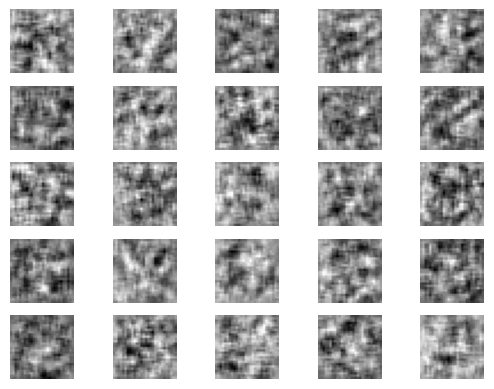

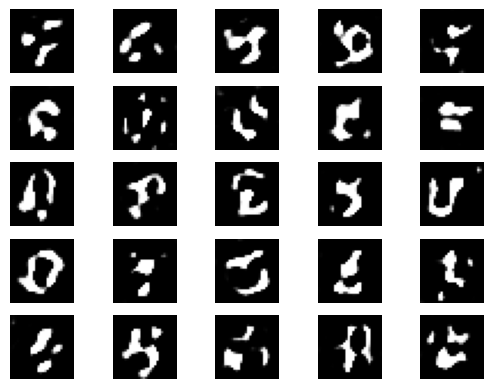

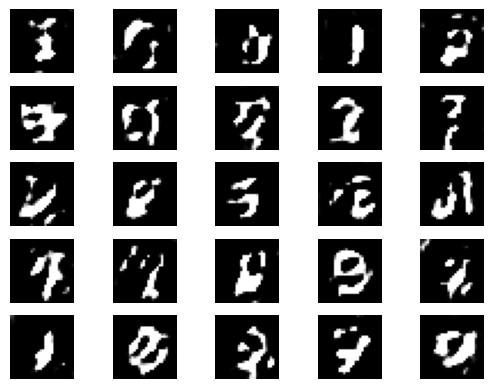

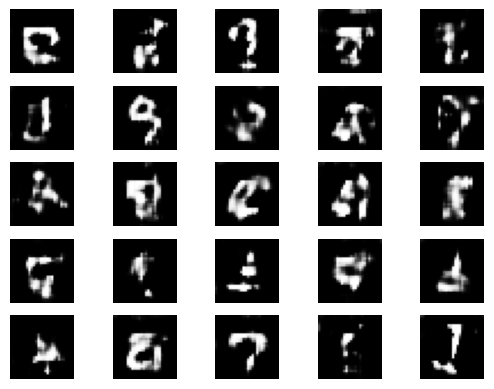

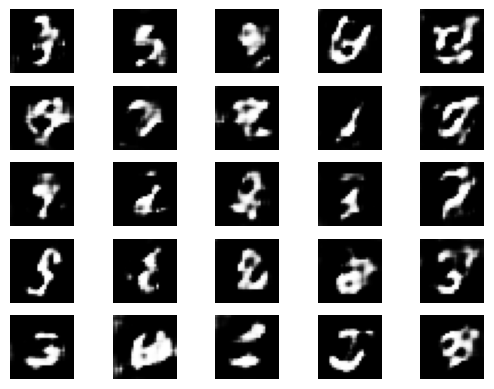

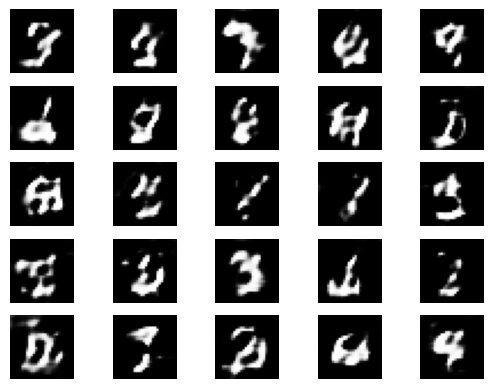

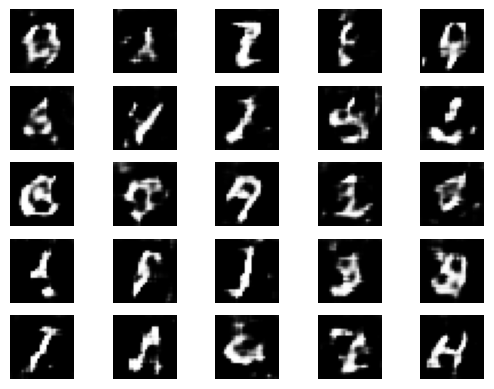

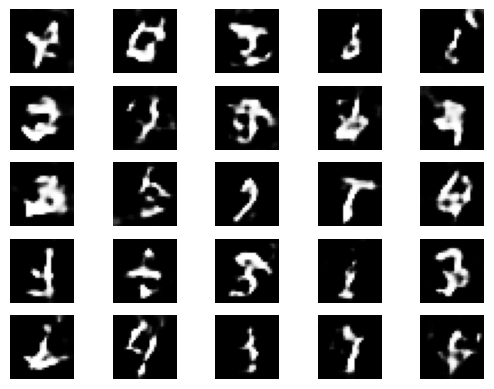

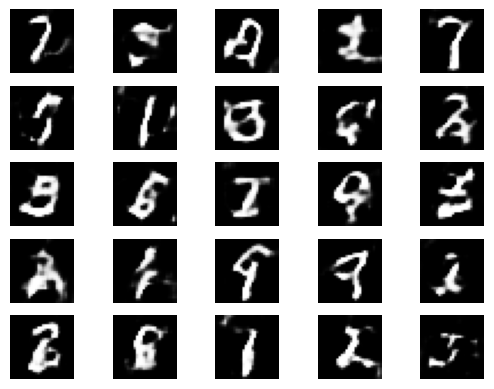

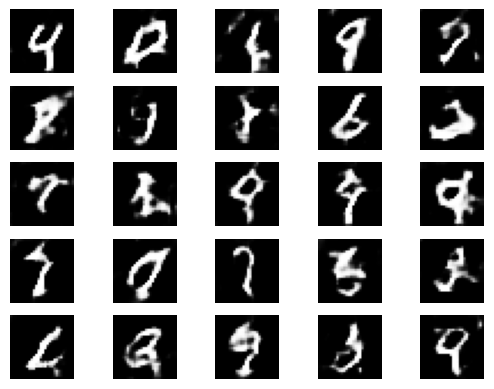

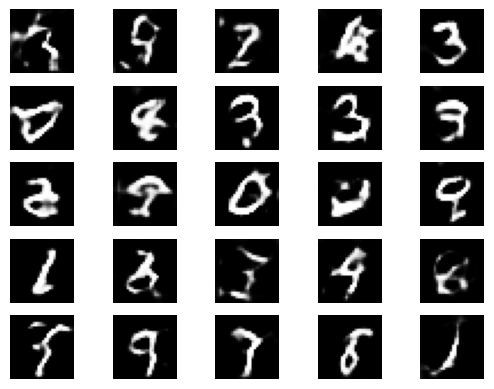

In [28]:
gan_train(2001,32,200)

In [34]:
from tensorflow.keras.layers \
     import Input, Dense, Reshape, Flatten, Dropout,MaxPooling2D, UpSampling2D

In [35]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')/255

In [36]:
# 생성자 모델을 만듭니다.
autoencoder = Sequential()

#인코딩 부분
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

#디코딩 부분 
#입력값에 맞게 이미미를 가져오기 위해서는 축소시킨 부분을 다시 원 크기로 만들어야 함.  
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인해 봅니다.
autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 8)          

Epoch 1/50
469/469 [==============================] - 57s 119ms/step - loss: 0.2246 - val_loss: 0.1397
Epoch 2/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1300 - val_loss: 0.1214
Epoch 3/50
469/469 [==============================] - 56s 119ms/step - loss: 0.1178 - val_loss: 0.1138
Epoch 4/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1119 - val_loss: 0.1081
Epoch 5/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1077 - val_loss: 0.1044
Epoch 6/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1045 - val_loss: 0.1019
Epoch 7/50
469/469 [==============================] - 56s 120ms/step - loss: 0.1020 - val_loss: 0.0996
Epoch 8/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1001 - val_loss: 0.0979
Epoch 9/50
469/469 [==============================] - 56s 118ms/step - loss: 0.0984 - val_loss: 0.0964
Epoch 10/50
469/469 [==============================] - 57s 121ms/step - l

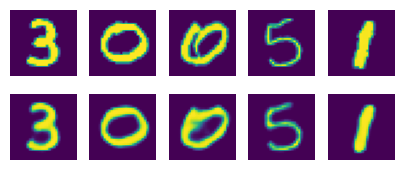

In [37]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, 
                validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분
# 테스트할 이미지를 랜덤하게 불러옴.
# 실제이미지 5개 추출
random_test = np.random.randint(X_test.shape[0], size=5) 
# 오토인코드 모델에 넣는다.
ae_imgs = autoencoder.predict(X_test) # autoencoder가 만든 이미지
# 출력이미지의 크기를 정한다.
plt.figure(figsize=(7, 2))

# 랜덤으로 뽐은 이미지를 차례로 나열
for i, image_idx in enumerate(random_test):       
    # 테스트 이미지 출력
    ax = plt.subplot(2, 7, i + 1) 
    plt.imshow(X_test[image_idx].reshape(28, 28))   
    ax.axis('off')
    # 오토 인코딩 결과를 출력
    ax = plt.subplot(2, 7, 7 + i +1)
    plt.imshow(ae_imgs[image_idx].reshape(28, 28)) 
    ax.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

#학습셋의 변형을 설정하는 부분입니다. 
train_datagen = ImageDataGenerator(rescale=1./255,          
                                  horizontal_flip=True,    
                                  width_shift_range=0.1,    
                                  height_shift_range=0.1,   
                                  rotation_range=5,        
                                  shear_range=0.7,         
                                  zoom_range=1.2,          
                                  vertical_flip=True,      
                                  fill_mode='nearest'      
                                  )      

train_generator = train_datagen.flow_from_directory(
       './data',   # 학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋은 이미지 부풀리기 과정을 진행하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)  

test_generator = test_datagen.flow_from_directory(
       './data',   # 테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')


# 앞서 배운 CNN 모델을 만들어 적용해 보겠습니다.
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

In [ ]:
!pip install SciPy

In [ ]:
#모델 실행의 옵션을 설정합니다. 
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

#모델을 실행합니다
history = model.fit(
       train_generator,
       epochs=100,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# 학습셋의 변형을 설정하는 부분입니다. 
train_datagen = ImageDataGenerator(rescale=1./255,          
                                  horizontal_flip=True,    
                                  width_shift_range=0.1,   
                                  height_shift_range=0.1,   
                                  rotation_range=5,        
                                  shear_range=0.7,         
                                  zoom_range=1.2,          
                                  vertical_flip=True,      
                                  fill_mode='nearest'      
                                  )      


train_generator = train_datagen.flow_from_directory(
       './data',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋의 정규화를 설정합니다.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       './data',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# VGG16 모델을 불러옵니다.
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

# 우리의 모델을 설정합니다.
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

In [ ]:
# 모델의 실행 옵션을 설정합니다. 
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

In [ ]:
!pip install tf-explain

In [ ]:
!pip install opencv-python

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16


from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


images_originals = []


for img_path in glob.glob('./data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))


plt.figure(figsize=(20,20))


for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_o)

In [ ]:

model = VGG16(weights="imagenet", include_top=True)


input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]


explainer = GradCAM()


images_cams = []


for l, i in zip(input_list, imagenet_index):  
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224)) 
    img = img_to_array(img) 
    data = ([img], None)
    grid = explainer.explain(data, model, int(i))                 
    explainer.save(grid, ".", './data/img/{}_cam.jpg'.format(l)) 


plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

In [ ]:
# 오클루전 알고리즘을 불러와 실행합니다.

explainer = OcclusionSensitivity()

# 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_occ1s = []

# 패치 사이즈를 정합니다. 
patch_size = 40

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) #패치 사이즈의 설정이 추가됩니다. 
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)


In [ ]:
patch_size = 20

images_occ2s = []

for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) 
    explainer.save(grid, ".", './data/img/{}_occ2.jpg'.format(l))

for img_path in glob.glob('./data/img/*_occ2.jpg'):
    images_occ2s.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
for i, image in enumerate(images_occ2s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

In [ ]:
# 전체 이미지 한 눈에 보기.

plt.figure(figsize=(20,20))

images = []
for img_path in glob.glob('./data/img/*.jpg'):
    images.append(mpimg.imread(img_path))

for i, image in enumerate(images):
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)